In [1]:
!pip install seaborn


import matplotlib.colors as pltcolors
from sklearn import svm, metrics
import seaborn as sns
import numpy as np
import torch
import warnings
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.colors as pltcolors
from matplotlib.colors import ListedColormap

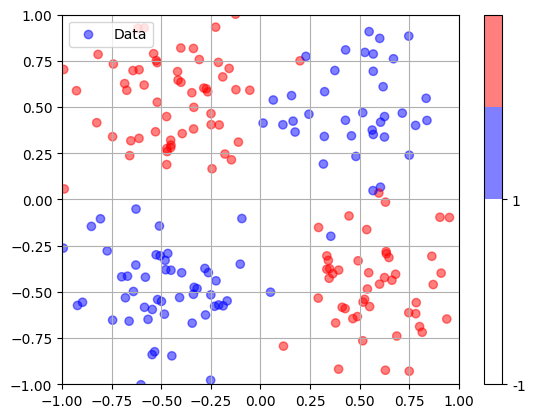

In [2]:
colours = ['blue', 'red']
custom_cmap = pltcolors.ListedColormap(colours)
num_features = 2
num_samples = 100

def display_heatmap(data, labels, title=None, format_spec='.2g', axis=None, x_label=None, y_label=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    axis = sns.heatmap(data, xticklabels=labels, yticklabels=labels, annot=True,
                        fmt=format_spec, cmap=plt.cm.Blues, ax=axis)
    bottom, top = axis.get_ylim()
    axis.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        axis.set_title(title)
    if x_label:
        axis.set_xlabel(x_label)
    if y_label:
        axis.set_ylabel(y_label)

def visualize_confusion_matrix(y_true, y_pred, labels, title=None, format_spec='.2g', axis=None):
    display_heatmap(metrics.confusion_matrix(y_true, y_pred), labels, title, format_spec, axis,
                    x_label='Predictions', y_label='True Labels')

def generate_xor_data(num_samples, mean=0.5, std_dev=0.5, random_seed=None):
    """
    Generate num_samples in a XOR pattern using Gaussian distributions.

    Parameters:
    - num_samples: number of samples
    - mean: mean of the Gaussian distribution
    - std_dev: standard deviation of the Gaussian distribution
    - random_seed: seed for the random number generators (default: None)

    Returns:
    - features: generated features
    - labels: generated labels
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    features = np.random.normal(mean, std_dev, (num_samples, 2))
    random_boolean_0 = np.random.uniform(0, 1, num_samples) > 0.5
    random_boolean_1 = np.random.uniform(0, 1, num_samples) > 0.5

    labels = np.logical_xor(random_boolean_0, random_boolean_1).astype(int)

    transformed_y0 = 2. * random_boolean_0 - 1
    transformed_y1 = 2. * random_boolean_1 - 1
    features[:, 0] *= transformed_y0
    features[:, 1] *= transformed_y1
    features -= features.mean(axis=0)

    return features, labels

seed_value = 42

def draw_line(axis, x_range, weights, intercept_point, label, line_color='grey', line_style='-', alpha_val=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if isinstance(intercept_point, (int, float, np.float64)):
        intercept_point = [0, -intercept_point / weights[1]]
    y_values = -(weights[0] / weights[1]) * (x_range - intercept_point[0]) + intercept_point[1]
    axis.plot(x_range, y_values, color=line_color, label=label, linestyle=line_style)

def plot_svm_decision_boundary(X, y, support_vectors=None, weights=None, intercept=0., data_label='Data',
                               separator_label='Separator', axis=None, boundary_limits=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if axis is None:
        fig, axis = plt.subplots(1)

    scatter_plot = axis.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, alpha=0.5, label=data_label)

    if support_vectors is not None:
        axis.scatter(support_vectors[:, 0], support_vectors[:, 1], label='Support Vectors', s=80,
                     facecolors='none', edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support_vectors)))

    if weights is not None:
        x_range = np.array(boundary_limits[0])
        draw_line(axis, x_range, weights, intercept, separator_label)

        # Plot margin
        if support_vectors is not None:
            signed_distances = np.matmul(support_vectors, weights)
            margin_distance = np.max(signed_distances) - np.min(signed_distances) * np.sqrt(np.dot(weights, weights))
            negative_support = support_vectors[np.argmin(signed_distances)]
            draw_line(axis, x_range, weights, negative_support, 'Margin -', line_style='-.', alpha_val=0.8)
            positive_support = support_vectors[np.argmax(signed_distances)]
            draw_line(axis, x_range, weights, positive_support, 'Margin +', line_style='--', alpha_val=0.8)
            axis.set_title('Margin = %.3f' % (margin_distance))

    axis.legend(loc='upper left')
    axis.grid()
    axis.set_xlim(boundary_limits[0])
    axis.set_ylim(boundary_limits[1])

    colorbar = plt.colorbar(scatter_plot, ax=axis)
    loc = np.arange(-1, 1, 1)
    colorbar.set_ticks(loc)
    colorbar.set_ticklabels(['-1', '1'])

# Generate and plot XOR data
X_train, y_train = generate_xor_data(200, std_dev=0.25, random_seed=seed_value)
plot_svm_decision_boundary(X_train, y_train)

X_test, y_test = generate_xor_data(50, std_dev=0.25, random_seed=seed_value)



In [15]:
import numpy as np
ket_00 = np.array([[1], [0], [0], [0]])
bra_00 = ket_00.T

hadamard= 1/np.sqrt(2.0) * np.array([[1,1],[1,-1]])
qubit_0 = np.array([[1],[0]])

def phase_gate(phi):
    return np.array([[1, 0], [0, np.exp(1j * phi)]])


def phase_gate(phi):
    return np.array([[1, 0],
                     [0, np.exp(1j * phi)]], dtype=complex)
def rx_gate(theta):
    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)
    return np.array([
        [cos, -1j * sin],
        [-1j * sin, cos]
    ])

def kernel(x1, x2):
    # Create the state S(x) |0..0>
    reg1 = phase_gate(2 * x1[0]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[0]) @ (rx_gate(np.pi / 2) @ (hadamard ))))
    reg2 = phase_gate(2 * x1[1]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[1]) @ (rx_gate(np.pi / 2) @ (hadamard))))
    SX = np.kron(reg1, reg2)

    # Create the state S(x') |0..0> for x2
    reg1 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[0]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[0])))))
    reg2 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[1]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[1])))))
    SX_dagger = np.kron(reg1, reg2)


    inner_product = SX_dagger @ SX
    # Calculate probability |<0..0|S(x')†S(x)|0..0>|^2
    probability = np.abs(bra_00@inner_product@ket_00) ** 2


    return probability[0][0]

def kernel_matrix(A, B):
    return np.array([[kernel(a, b) for b in B] for a in A])

print(torch.tensor(kernel([0.5,0.5],[0.5,0.5]), requires_grad=True))
svm_pre_quantum = svm.SVC(kernel=kernel_matrix)
svm_pre_quantum.fit(X_train,y_train)
predictions_pre = svm_pre_quantum.predict(X_test)
accuracy_quant = accuracy_score(y_test, predictions_pre)
print(accuracy_quant)
support_indices = svm_pre_quantum.support_
support_vectors = X_train[support_indices]
dual = svm_pre_quantum.dual_coef_[0]
print(f1_score(y_test, predictions_pre))
print(precision_score(y_test, predictions_pre))
print(recall_score(y_test, predictions_pre))

tensor(1.0000, dtype=torch.float64, requires_grad=True)
0.9
0.9019607843137255
0.8846153846153846
0.92


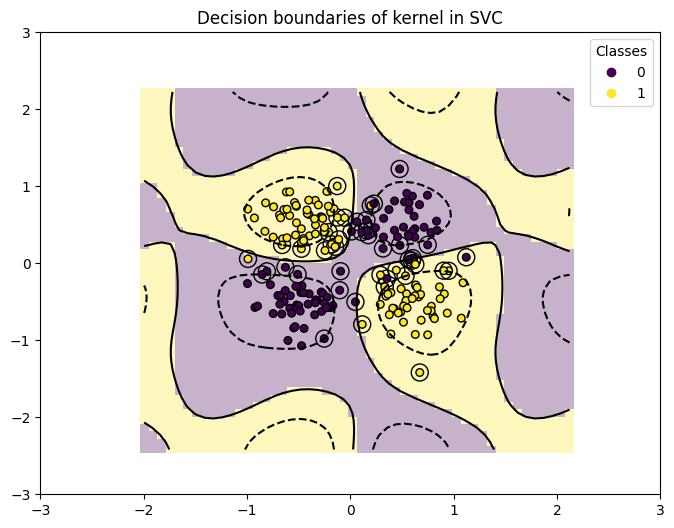

In [16]:
import numpy as np
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

def plot_training_data_with_decision_boundary(kernel='linear', ax=None, long_title=True, sv=None, clf=None, resolution=100):
    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size

    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))


    common_params = {"estimator": clf, "X": X, "ax": ax}

    # Lower resolution for faster plotting
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
        grid_resolution=resolution
    )

    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        grid_resolution=resolution  # Set the grid resolution for contour plotting
    )

    ax.scatter(
      sv[:, 0],
      sv[:, 1],
      s=150,
      facecolors="none",
      edgecolors="k",
    )

    # Plot samples by color and add legend
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

    # Add titles
    if long_title:
        ax.set_title(f"Decision boundaries of kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

# Call the function with the trained SVM model and optimized parameters
plot_training_data_with_decision_boundary(sv=support_vectors, clf=svm_pre_quantum, resolution=50)  # Set resolution to 50 for faster performance


In [ ]:
def ry_gate(theta):
    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)
    return np.array([
        [cos, -sin],
        [sin, cos]
    ])
t_values = np.linspace(1, 10, 10)

def conformal_transform_subtraction(sv, x1, x2,t):
    svs = sv
    regA = ry_gate((x1[0]-svs[0] )/t) @ hadamard
    regB = ry_gate((x1[0]-svs[1])/t) @ hadamard
    SS = np.kron(regA, regB)

    regA = hadamard @ ry_gate(-(x2[0]-svs[0] )/t)
    regB = hadamard @ ry_gate(-(x2[1]-svs[1])/t)
    SS_dagger = np.kron(regA, regB)

    inner_product_sv = SS_dagger @ SS
    probability_sv = np.abs(bra_00 @ inner_product_sv @ ket_00) ** 2
    return probability_sv[0][0]

# Kernel function that uses the conformal transformations and `t` parameter
def modified_kernel(x1, x2, t, support_vectors):
    reg1 = phase_gate(2 * x1[0]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[0]) @ (rx_gate(np.pi / 2) @ hadamard)))
    reg2 = phase_gate(2 * x1[1]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[1]) @ (rx_gate(np.pi / 2) @ hadamard)))
    SX = np.kron(reg1, reg2)

    # Create the state S(x') |0..0> for x2
    reg1 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[0]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[0])))))
    reg2 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[1]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[1])))))
    SX_dagger = np.kron(reg1, reg2)

    # Calculate inner product S(x')†S(x)
    inner_product = SX_dagger @ SX
    # Calculate probability |<0..0|S(x')†S(x)|0..0>|^2
    probability = np.abs(bra_00 @ inner_product @ ket_00) ** 2

    probabilities_sv = np.apply_along_axis(conformal_transform_subtraction, 1, support_vectors, x1, x2, t)

    total_probability = np.sum(probabilities_sv * probability)

    return total_probability

def kernel_matrix(A, B, t, support_vectors):
    return np.array([[modified_kernel(a, b, t, support_vectors) for b in B] for a in A])

# Loop over t_values and apply transformations
for t in t_values:
    # Define the custom kernel function with current t and support vectors
    kernel = lambda A, B: kernel_matrix(A, B, t, support_vectors)

    # Fit the modified SVM with the custom kernel
    svm_modified_quantum = svm.SVC(kernel=kernel)
    svm_modified_quantum.fit(X_train, y_train)

    predictions = svm_modified_quantum.predict(X_test)
    accuracy_quant = accuracy_score(y_test, predictions)

    print(f"Accuracy with conformal transformation and t={t}: {accuracy_quant}")

Accuracy with conformal transformation and t=1.0: 0.94
Accuracy with conformal transformation and t=2.0: 0.96
Accuracy with conformal transformation and t=3.0: 0.96
Accuracy with conformal transformation and t=4.0: 0.96
Accuracy with conformal transformation and t=5.0: 0.96
Accuracy with conformal transformation and t=6.0: 0.96
Accuracy with conformal transformation and t=7.0: 0.96
Accuracy with conformal transformation and t=8.0: 0.96
Accuracy with conformal transformation and t=9.0: 0.96
Accuracy with conformal transformation and t=10.0: 0.94


Accuracy with conformal transformation and t=2.0: 0.96
0.9583333333333334
1.0
0.92


IndexError: invalid index to scalar variable.

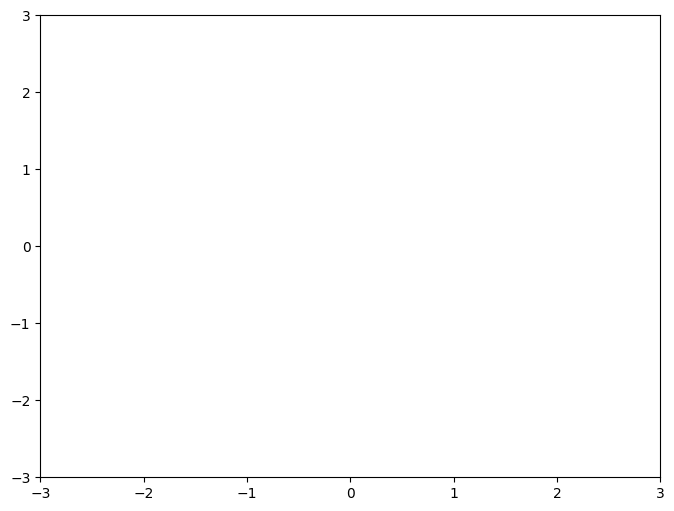

In [17]:
def ry_gate(theta):
    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)
    return np.array([
        [cos, -sin],
        [sin, cos]
    ])
t_values = np.linspace(2, 2, 1)

def conformal_transform_subtraction(sv, x1, x2,t):
    svs = sv
    regA = ry_gate((x1[0]-svs[0] )/t) @ hadamard
    regB = ry_gate((x1[0]-svs[1])/t) @ hadamard
    SS = np.kron(regA, regB)

    regA = hadamard @ ry_gate(-(x2[0]-svs[0] )/t)
    regB = hadamard @ ry_gate(-(x2[1]-svs[1])/t)
    SS_dagger = np.kron(regA, regB)

    inner_product_sv = SS_dagger @ SS
    probability_sv = np.abs(bra_00 @ inner_product_sv @ ket_00) ** 2
    return probability_sv[0][0]

# Kernel function that uses the conformal transformations and `t` parameter
def modified_kernel(x1, x2, t, support_vectors):
    reg1 = phase_gate(2 * x1[0]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[0]) @ (rx_gate(np.pi / 2) @ hadamard)))
    reg2 = phase_gate(2 * x1[1]) @ (rx_gate(-np.pi / 2) @ (phase_gate(2 * x1[1]) @ (rx_gate(np.pi / 2) @ hadamard)))
    SX = np.kron(reg1, reg2)

    # Create the state S(x') |0..0> for x2
    reg1 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[0]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[0])))))
    reg2 = hadamard @ (rx_gate(-np.pi / 2) @ (phase_gate(-2 * x2[1]) @ (rx_gate(np.pi / 2) @ (phase_gate(-2 * x2[1])))))
    SX_dagger = np.kron(reg1, reg2)

    # Calculate inner product S(x')†S(x)
    inner_product = SX_dagger @ SX
    # Calculate probability |<0..0|S(x')†S(x)|0..0>|^2
    probability = np.abs(bra_00 @ inner_product @ ket_00) ** 2

    probabilities_sv = np.apply_along_axis(conformal_transform_subtraction, 1, support_vectors, x1, x2, t)

    total_probability = np.sum(probabilities_sv)*probability[0][0]

    return total_probability

def kernel_matrix(A, B, t, support_vectors):
    return np.array([[modified_kernel(a, b, t, support_vectors) for b in B] for a in A])

# Loop over t_values and apply transformations
for t in t_values:
    # Define the custom kernel function with current t and support vectors
    kernel = lambda A, B: kernel_matrix(A, B, t, support_vectors)

    # Fit the modified SVM with the custom kernel
    svm_modified_quantum = svm.SVC(kernel=kernel)
    svm_modified_quantum.fit(X_train, y_train)

    predictions = svm_modified_quantum.predict(X_test)
    accuracy_quant = accuracy_score(y_test, predictions)

    print(f"Accuracy with conformal transformation and t={t}: {accuracy_quant}")
    print(f1_score(y_test, predictions))
    print(precision_score(y_test, predictions))
    print(recall_score(y_test, predictions))
    support_indices = svm_modified_quantum.support_
    support_vectors = X_train[support_indices]
    plot_training_data_with_decision_boundary(sv=support_vectors, clf=svm_pre_quantum, resolution=50)
    # plot_training_data_with_decision_boundary(sv= support_vectors,clf=svm_modified_quantum)

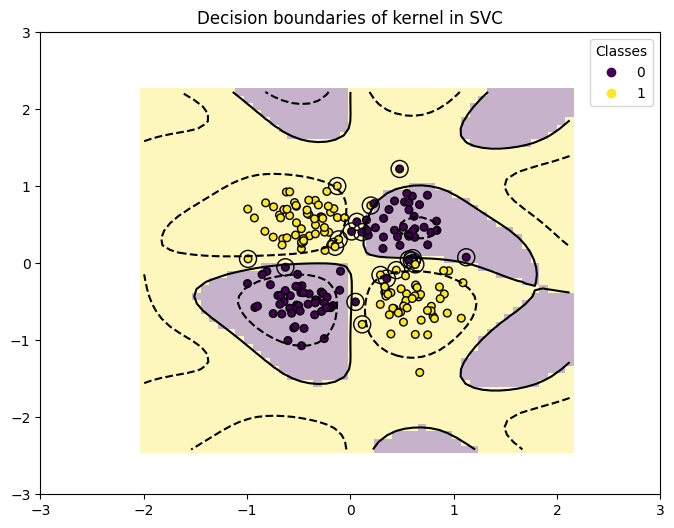

In [18]:
  plot_training_data_with_decision_boundary(sv=support_vectors, clf=svm_modified_quantum, resolution=50)

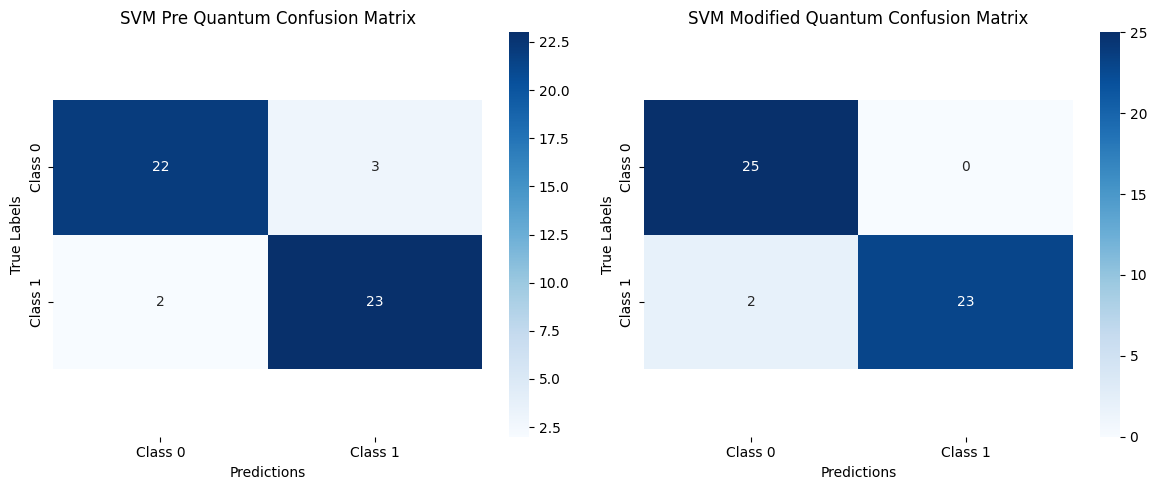

In [ ]:
labels = ['Class 0', 'Class 1']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

visualize_confusion_matrix(y_test, predictions_pre, labels, title='SVM Pre Quantum Confusion Matrix', axis=axes[0])

visualize_confusion_matrix(y_test, predictions, labels, title='SVM Modified Quantum Confusion Matrix', axis=axes[1])

plt.tight_layout()
plt.show()